# Error Mitigation

In [2]:
%load_ext autoreload
%autoreload 2

import os
ROOT_DIR = os.getcwd()[:os.getcwd().rfind('NVcenter')]+ 'NVcenter'
os.chdir(ROOT_DIR)

from NVcenter import *
plt.style.use('NVcenter-default')

import numpy as np 
import matplotlib.pyplot as plt
import qutip as q

In [2]:
import scipy.constants as c
r = 10e-9
Azz = 2 * ( (c.h * c.mu_0) / (4 * np.pi * r**3) * CONST['gamma_e']**2 ) / (2 * np.pi) 
Azz * 1e-6 * 2*np.pi

4.110474491853669

## Small Systems of NV center and Surface Electron Spin 

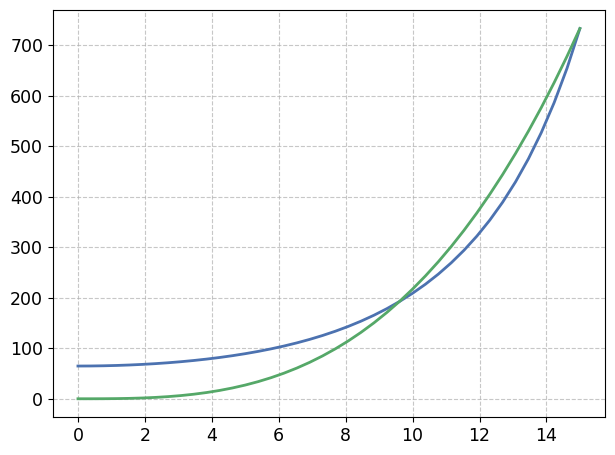

In [46]:
rz = 15e-9
rx = np.linspace(0, 15e-9, 40)
prefactor = -(c.hbar * c.mu_0) / (4 * np.pi) * CONST['gamma_e']**2

fig, ax = plt.subplots()
ax.plot(rx*1e9, abs(4*np.pi/prefactor *1e6 * (rx**2+rz**2)**(5/2)/(2*rz**2-rx**2) ))
ax.plot(rx*1e9, abs(4*np.pi/prefactor *1e6 * 2**(5/2)*rx**3) )

In [465]:
prefactor = (c.hbar * c.mu_0) / (4 * np.pi) * CONST['gamma_e']**2 / (2*np.pi)
period_fraction = 2

radius = 12e-9
t = 1/4 * abs(prefactor) * 1/radius**3 # element in the Hamiltonian 
period = 1/(2*t)
time = period/period_fraction *1e6
a = 8*np.pi**2/(c.hbar*c.mu_0*CONST['gamma_e']**2) *1e-27 *1e6
1/a

52.05976760578134

[[-60254.36065484      0.              0.        ]
 [     0.          30127.18032742     -0.        ]
 [     0.             -0.          30127.18032742]]


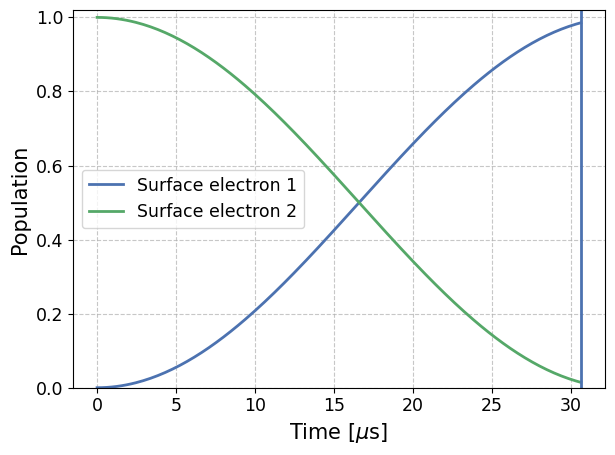

In [452]:
# surface spin flip flop interaction
radius = 12e-9
register_config = [('e', (0,0, 1e-08), 1, dict(Bz=300e-4)), ('e', (radius,0, 1e-08), 0, dict(Bz=300e-4))]
kwargs = dict(suter_method=False, verbose=False, env_approx_level = 'no_bath')
env = Environment2(register_config, **kwargs)

env.gate_props_list = [('free_evo', dict(t=0.e-6))]

t_end = calc_interaction_sphere(radius=radius)
t_list = np.linspace(0, t_end, 200)
states = env.calc_states(t_list)[0,:]

e1_dms = [dm.ptrace(0) for dm in states]
e2_dms = [dm.ptrace(1) for dm in states]

fig, ax = plt.subplots()
ax.plot(t_list*1e6, [dm[0,0].real for dm in e1_dms], label='Surface electron 1')
ax.plot(t_list*1e6, [dm[0,0].real for dm in e2_dms], label='Surface electron 2')
ax.set_ylim(0,1.02)
ax.set_ylabel(r'Population')
ax.set_xlabel(r'Time [$\mu$s]')
ax.legend()

ax.axvline(x=t_end *1e6)
plt.show()

## Create Spin Baths

In [43]:
# create, save and load a spinbath
num_baths, num_init_states, all_init_states = 1000, 1, False
directory = os.getcwd()
filename = os.path.join( "baths", "test123")
kwargs = dict(
    density = 1e-3 / 1e-18, # spins/nm^2 # 1e-3 - 50e-3
    shape = 'circle',
    rmin = 0, 
    rmax = 50e-9,
    bath_kwargs = dict(Bz=500e-4, depth=10e-9),
)

spin_bath = SpinBath('e', **kwargs)
bath_configs, metadata = spin_bath.calc_spin_baths(num_baths, num_init_states, all_init_states=all_init_states)

print("Number of bath spins: ", spin_bath.num_spins)
bath_polarization = calc_bath_polarization(bath_configs)
print("Bath Polarization: ", bath_polarization)

save_spin_baths(bath_configs, metadata, directory, filename)
bath_configs = load_spin_baths(filename, directory)
#fig, ax = visualize_spin_bath(bath_configs, metadata)

Number of bath spins:  7
Bath Polarization:  1.5


In [15]:
rmin, rmax = 0, 30e-9
cutoff = np.sqrt( (10e-9)**2 + (rmax)**2)
bath_configs_filtered = cut_spin_bath(bath_configs, cutoff)

filename = os.path.join( "baths", "delete_4")
save_spin_baths(bath_configs_filtered, metadata, directory, filename)

In [4]:
bath_configs_fix = []

fix_spin = ['e', (2e-9,0,10e-9), 0, kwargs['bath_kwargs']]
bath_configs = load_spin_baths(filename, directory)
for bath_config in bath_configs:
    bath_config.extend([fix_spin])
    bath_configs_fix.append(bath_config)

bath_configs = load_spin_baths(filename, directory)
fix_spin = ['e', (0,0,10e-9), 1, kwargs['bath_kwargs']]
for bath_config in bath_configs:
    bath_config.extend([fix_spin])
    bath_configs_fix.append(bath_config)
    
filename += '_fix' 
save_spin_baths(bath_configs_fix, metadata, directory, filename)
bath_configs = load_spin_baths(filename, directory)

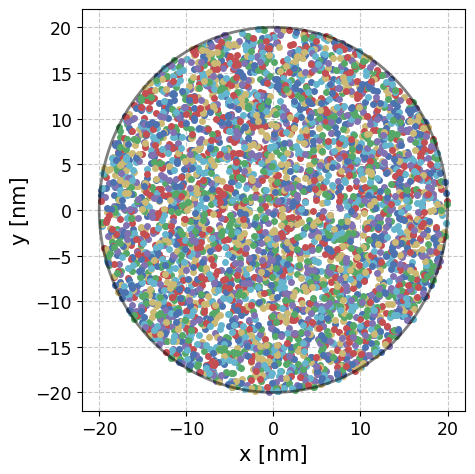

In [40]:
# cut an existing spin bath
rmin, rmax = 0, 20e-9
cutoff = np.sqrt( (10e-9)**2 + (rmax)**2)

directory = os.getcwd()
filename = os.path.join( "baths", "new3")

bath_configs_filtered = cut_spin_bath(bath_configs, cutoff)
metadata = {'rmin': rmin, 'rmax': rmax}

# bath_polarization = calc_bath_polarization(bath_configs_filtered)
# print("Bath Polarization: ", bath_polarization)

save_spin_baths(bath_configs_filtered, metadata, directory, filename)
bath_configs = load_spin_baths(filename, directory)
fig, ax = visualize_spin_bath(bath_configs_filtered, metadata)

## Ramsey (takes long)

In [5]:
# Pauli expectation values
# %%time
directory = os.path.join(os.getcwd(), "baths")
filename = "dwyer_density_16nm_thermal"
bath_configs = load_spin_baths(filename, directory)

import time
t0 = time.time()

for Bz in [200e-9]:
    for env_approx_level in ['full_bath']:
        register_config = [('NV', (0, 0, 0), 0, dict(D_gs=0, Bz=Bz, N_zz=0, can_flip=False))]
        kwargs = dict(dm_offset=1e-5, verbose=False, env_approx_level=env_approx_level, bath_configs=bath_configs, suter_method=False, thermal_bath=True, parallelization=True)
        env = Environment2(register_config, **kwargs)
        
        t_end, t_steps = 10e-6, 500
        t_list = np.linspace(0, t_end, t_steps)
        miri_list = calc_miri_list(env, t_end, t_steps, pauli=True) # pauli=False for populations
        
        # saving
        save_directory = os.path.join(os.getcwd(), "export", filename)
        os.makedirs(save_directory, exist_ok=True)
        save_filename = f"{env.env_approx_level}_{int(Bz*1e9)}nT_Pauli"
        save_loc = os.path.join(save_directory, save_filename)
        np.save(save_loc, miri_list)
        print("Time: ", time.time()-t0)
        print(f'Saved as {save_loc}.npy')

Sampling over spin baths...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:19<00:00, 12.64it/s]


Time:  92.5199384689331
Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\dwyer_density_16nm_thermal\full_bath_200nT_Pauli.npy


In [37]:
# populations
# %%time
directory = os.path.join(os.getcwd(), "baths")
filename = "new2"
bath_configs = load_spin_baths(filename, directory)

import time
t0 = time.time()

for Bz in [0e-6]:
    for env_approx_level in ['full_bath']:#, 'gCCE0', 'gCCE1', 'gCCE2', 'full_bath']:
        register_config = [('NV', (0, 0, 0), 0, dict(D_gs=0, Bz=Bz, N_zz=0, can_flip=False))]
        kwargs = dict(dm_offset=1e-5, verbose=False, env_approx_level=env_approx_level, bath_configs=bath_configs, suter_method=False, thermal_bath=True, parallelization=True)
        env = Environment2(register_config, **kwargs)
        
        t_end, t_steps = 100e-6, 500
        t_list = np.linspace(0, t_end, t_steps)
        miri_list = calc_miri_list(env, t_end, t_steps, pauli=False, old_register_states=[q.fock_dm(2,0)]) # pauli=False for populations
        
        # saving
        save_directory = os.path.join(os.getcwd(), "export", filename)
        os.makedirs(save_directory, exist_ok=True)
        save_filename = f"{env.env_approx_level}_{int(Bz*1e9)}nT"
        save_loc = os.path.join(save_directory, save_filename)
        np.save(save_loc, miri_list)
        print("Time: ", time.time()-t0)
        print(f'Saved as {save_loc}.npy')

Sampling over spin baths...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:45<00:00, 110.25it/s]


Time:  49.228798389434814
Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\new2\full_bath_0nT.npy


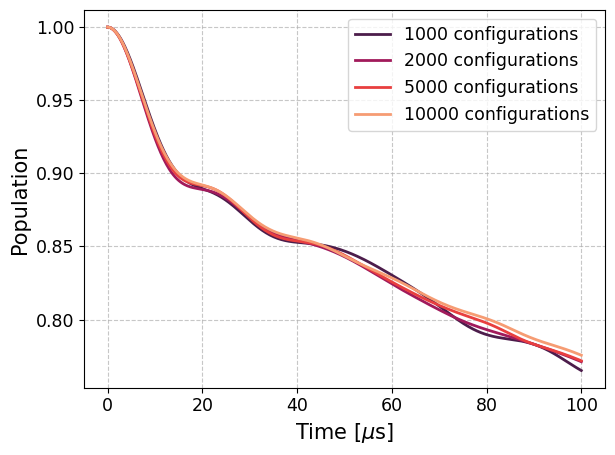

In [38]:
import seaborn as sns

colors = sns.color_palette('rocket', n_colors=4)

fig, ax = plt.subplots()

save_directory = os.path.join(os.getcwd(), "export", "new")
save_filename = os.path.join('full_bath_0nT')
save_loc = os.path.join(save_directory, save_filename)
miri_list = np.load(save_loc + ".npy")

ax.plot(t_list * 1e6, miri_list[0,0], color=colors[0], label='1000 configurations')

save_directory = os.path.join(os.getcwd(), "export", "new1")
save_filename = os.path.join('full_bath_0nT')
save_loc = os.path.join(save_directory, save_filename)
miri_list = np.load(save_loc + ".npy")

ax.plot(t_list * 1e6, miri_list[0,0], color=colors[1], label='2000 configurations')

save_directory = os.path.join(os.getcwd(), "export", "new2")
save_filename = os.path.join('full_bath_0nT')
save_loc = os.path.join(save_directory, save_filename)
miri_list = np.load(save_loc + ".npy")

ax.plot(t_list * 1e6, miri_list[0,0], color=colors[2], label='5000 configurations')

save_directory = os.path.join(os.getcwd(), "export", "new3")
save_filename = os.path.join('full_bath_0nT')
save_loc = os.path.join(save_directory, save_filename)
miri_list = np.load(save_loc + ".npy")

ax.plot(t_list * 1e6, miri_list[0,0], color=colors[3], label='10000 configurations')

ax.legend()
ax.set_ylabel('Population')
ax.set_xlabel(r'Time [$\mu$s]' )
# ax.set_ylim(0,1.02)
plt.show()

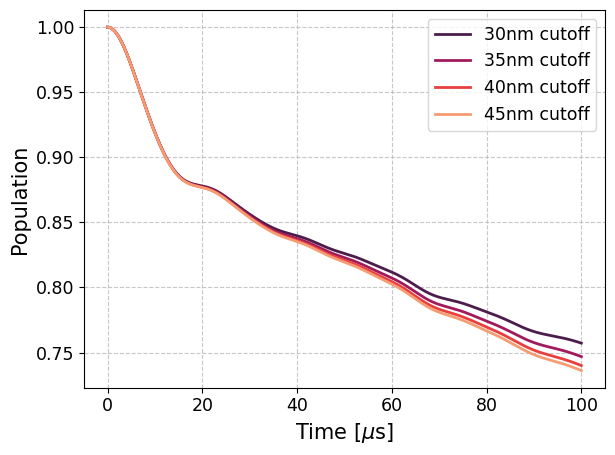

In [44]:
import seaborn as sns

colors = sns.color_palette('rocket', n_colors=4)

fig, ax = plt.subplots()

save_directory = os.path.join(os.getcwd(), "export", "delete_4")
save_filename = os.path.join('full_bath_0nT')
save_loc = os.path.join(save_directory, save_filename)
miri_list = np.load(save_loc + ".npy")

ax.plot(t_list * 1e6, miri_list[0,0], color=colors[0], label='30nm cutoff')

save_directory = os.path.join(os.getcwd(), "export", "delete_3")
save_filename = os.path.join('full_bath_0nT')
save_loc = os.path.join(save_directory, save_filename)
miri_list = np.load(save_loc + ".npy")

ax.plot(t_list * 1e6, miri_list[0,0], color=colors[1], label='35nm cutoff')

save_directory = os.path.join(os.getcwd(), "export", "delete_2")
save_filename = os.path.join('full_bath_0nT')
save_loc = os.path.join(save_directory, save_filename)
miri_list = np.load(save_loc + ".npy")

ax.plot(t_list * 1e6, miri_list[0,0], color=colors[2], label='40nm cutoff')

save_directory = os.path.join(os.getcwd(), "export", "delete_1")
save_filename = os.path.join('full_bath_0nT')
save_loc = os.path.join(save_directory, save_filename)
miri_list = np.load(save_loc + ".npy")

ax.plot(t_list * 1e6, miri_list[0,0], color=colors[3], label='45nm cutoff')

ax.legend()
ax.set_ylabel('Population')
ax.set_xlabel(r'Time [$\mu$s]' )
# ax.set_ylim(0,1.02)
plt.show()

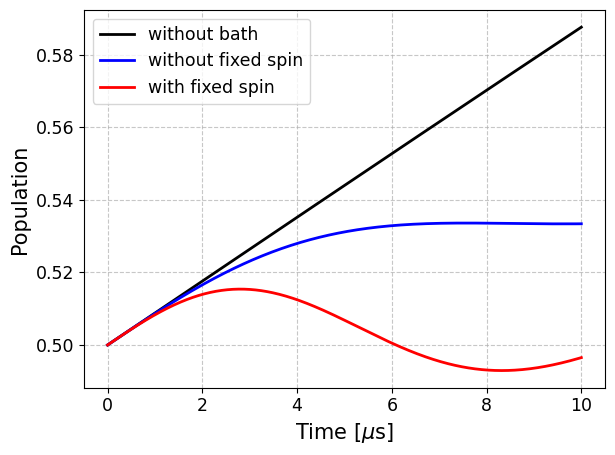

In [97]:
fig, ax = plt.subplots()

save_directory = os.path.join(os.getcwd(), "export", "dwyer_density_16nm_thermal")
save_filename = os.path.join('no_bath_100nT')
save_loc = os.path.join(save_directory, save_filename)
miri_list = np.load(save_loc + ".npy")

ax.plot(t_list * 1e6, miri_list[0,0], color='k', label='without bath')

save_directory = os.path.join(os.getcwd(), "export", "dwyer_density_16nm_thermal")
save_filename = os.path.join('full_bath_100nT')
save_loc = os.path.join(save_directory, save_filename)
miri_list = np.load(save_loc + ".npy")

ax.plot(t_list * 1e6, miri_list[0,0], color='b', label='without fixed spin')

save_directory = os.path.join(os.getcwd(), "export", "dwyer_density_16nm_thermal_fix")
save_filename = os.path.join('full_bath_100nT')
save_loc = os.path.join(save_directory, save_filename)
miri_list = np.load(save_loc + ".npy")

ax.plot(t_list * 1e6, miri_list[0,0], color='r', label='with fixed spin')
# ax.plot(t_list * 1e6, miri_list[0,1], color='r')

ax.legend()
ax.set_ylabel('Population')
ax.set_xlabel(r'Time [$\mu$s]' )
# ax.set_ylim(0,1.02)
plt.show()

## Plots

In [16]:
register_config = [('NV', (0, 0, 0), 0, dict(D_gs=0, Bz=0, N_zz=0, can_flip=False))]
kwargs = dict(dm_offset=1e-5, verbose=True, env_approx_level='gCCE0', bath_configs=bath_configs[15:16], suter_method=False, thermal_bath=True, parallelization=True)
env = Environment2(register_config, **kwargs)

t_end, t_steps = 200e-6, 200
t_list = np.linspace(0, t_end, t_steps)
miri_list = calc_miri_list(env, t_end, t_steps, pauli=False, old_register_states=[q.fock_dm(2,0)]) # pauli=False for populations

fig, ax = plt.subplots()

idx=0
ax.plot(t_list * 1e6, miri_list[0][idx], label=r'$P(m_s=0)$')
ax.plot(t_list * 1e6, miri_list[1][idx], label=r'$P(m_s=-1)$')

ax.set_ylabel('Population')
ax.set_xlabel(r'Time [$\mu$s]' )
ax.legend()
plt.show()

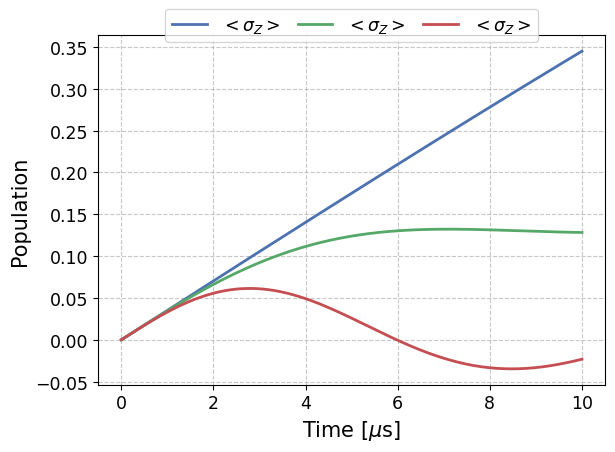

In [6]:
fig, ax = plt.subplots()

save_directory = os.path.join(os.getcwd(), "export", "dwyer_density_16nm_thermal")
save_filename = os.path.join('no_bath_200nT_Pauli')
save_loc = os.path.join(save_directory, save_filename)
miri_list = np.load(save_loc + ".npy")

idx = 4
t_end, t_steps = 10e-6, 500
t_list = np.linspace(0, t_end, t_steps)
# ax.plot(t_list * 1e6, miri_list[idx, 0], label=r'$<\sigma_X>$')
# ax.plot(t_list * 1e6, miri_list[idx, 1], label=r'$<\sigma_Y>$')
ax.plot(t_list * 1e6, miri_list[idx, 2], label=r'$<\sigma_Z>$')

save_directory = os.path.join(os.getcwd(), "export", "dwyer_density_16nm_thermal")
save_filename = os.path.join('full_bath_200nT_Pauli')
save_loc = os.path.join(save_directory, save_filename)
miri_list = np.load(save_loc + ".npy")

idx = 4
t_end, t_steps = 10e-6, 500
t_list = np.linspace(0, t_end, t_steps)
# ax.plot(t_list * 1e6, miri_list[idx, 0], label=r'$<\sigma_X>$')
# ax.plot(t_list * 1e6, miri_list[idx, 1], label=r'$<\sigma_Y>$')
ax.plot(t_list * 1e6, miri_list[idx, 2], label=r'$<\sigma_Z>$')

save_directory = os.path.join(os.getcwd(), "export", "dwyer_density_16nm_thermal_fix")
save_filename = os.path.join('full_bath_200nT_Pauli')
save_loc = os.path.join(save_directory, save_filename)
miri_list = np.load(save_loc + ".npy")

idx = 4
t_end, t_steps = 10e-6, 500
t_list = np.linspace(0, t_end, t_steps)
# ax.plot(t_list * 1e6, miri_list[idx, 0], label=r'$<\sigma_X>$')
# ax.plot(t_list * 1e6, miri_list[idx, 1], label=r'$<\sigma_Y>$')
ax.plot(t_list * 1e6, miri_list[idx, 2], label=r'$<\sigma_Z>$')

ax.set_ylabel('Population')
ax.set_xlabel(r'Time [$\mu$s]' )
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3, columnspacing=1, fontsize='small')  
plt.show()

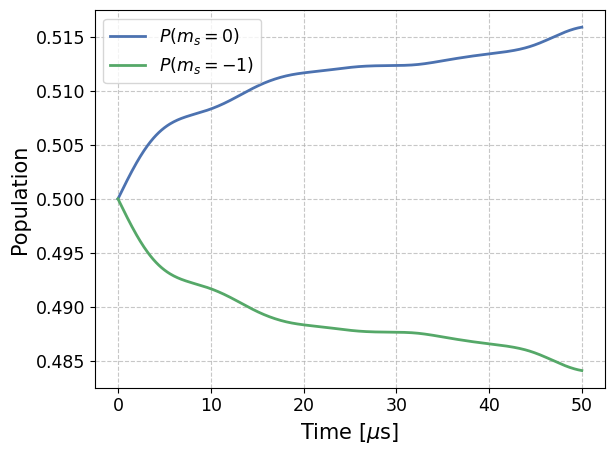

In [5]:
fig, ax = plt.subplots()

save_directory = os.path.join(os.getcwd(), "export", "bench_full15")
save_filename = os.path.join('full_bath_20nT')
save_loc = os.path.join(save_directory, save_filename)
miri_list = np.load(save_loc + ".npy")

idx=0
t_end, t_steps = 50e-6, 500
t_list = np.linspace(0, t_end, t_steps)
ax.plot(t_list * 1e6, miri_list[idx, 0], label=r'$P(m_s=0)$')
ax.plot(t_list * 1e6, miri_list[idx, 1], label=r'$P(m_s=-1)$')

ax.set_ylabel('Population')
ax.set_xlabel(r'Time [$\mu$s]' )
ax.legend()
plt.show()